In [1]:
import micropip
await micropip.install("scipy")
await micropip.install("matplotlib")
await micropip.install("pyodide-http")
await micropip.install("autograd")

import pyodide_http
pyodide_http.patch_all()

from data import load_mnist

import autograd.numpy as np
from autograd import grad
import numpy

In [2]:
class nnParameter:
    def __init__(self, val, requires_grad=True):
        self.val = val
        self.requires_grad = requires_grad
        self.is_training = False

    @property
    def name(self):
        return self._name

    @name.setter
    def name(self, value):
        self._name = value

    def value(self):
        if self.is_training:
            return self.rebinded
        else:
            return self.val

class OptimizerSGD:
    def __init__(self, param_list, hyper_params):
        self.param_list = param_list
        self.hyper_params = hyper_params

    def steps(self):
        for param in self.param_list.values():
            param.val -= self.hyper_params["lambda"] * param.grad


In [3]:
def join_path(prefix, path):
    if len(prefix) == 0:
        return path
    else:
        return prefix + "." + path

def flatten_path_rep(prefix, lst):
    res = []
    for i, x in enumerate(lst):
        res.append((join_path(prefix, "[{i}]".format(i=i)), x))
    return res

class nnModule:
    def __init__(self):
        self._cache = 123

    def _get_attrs_filter(self, param=False, module=False, state=False):
        internal = { "_cache" }
        res = {}
        for k, v in self.__dict__.items():
            if k in internal:
                continue
            if isinstance(v, nnParameter) or \
                (isinstance(v, list) and all([isinstance(x, nnParameter) for x in v])):
                if param:
                    res[k] = v
            elif isinstance(v, nnModule) or \
                (isinstance(v, list) and all([isinstance(x, nnModule) for x in v])):
                if module:
                    res[k] = v
            elif state:
                res[k] = v
        return res
    def _get_submodules(self, prefix=""):
        result = {}
        for k, v in self._get_attrs_filter(module=True).items():
            if isinstance(v, list):
                for kp, vp in flatten_path_rep(k, v):
                    result[join_path(prefix, kp)] = vp
            else:
                result[join_path(prefix, k)] = v
        return result
    
    def get_parameters(self, nested=True, prefix=""):
        result = {}
        for k, v in self._get_attrs_filter(param=True).items():
            if isinstance(v, list):
                for kp, vp in flatten_path_rep(k, v):
                    result[join_path(prefix, kp)] = vp
            else:
                result[join_path(prefix, k)] = v
        if nested:
            submodule_params = [m.get_parameters(nested=True, prefix=path) \
                                for (path, m) in self._get_submodules().items()]
            for submodule_param in submodule_params:
                for k, v in submodule_param.items():
                    result[join_path(prefix, k)] = v
        return result

    def _set_train(self, is_training):
        for k, v in self.get_parameters(nested=True).items():
            v.name = k
            v.is_training = is_training
            #v.grad = np.zeros(v.val.shape)

    def backward(self, *inputs):
        # Hack
        self._set_train(True)
        params = self.get_parameters(nested=True)
        def rebind(ins):
            for k, v in ins.items():
                params[k].rebinded = v
            return self.forward(*inputs)
        params_cur_val = {}
        for k, v in params.items():
            params_cur_val[k] = v.val
        for k, v in grad(rebind)(params_cur_val).items():
            params[k].grad = v
        self._set_train(False)

class Dev(nnModule):
    def __init__(self, a, b, c):
        super().__init__()
        self.a = a
        self.b = b
        self.c = c

class MoreLayer(nnModule):
    def __init__(self, n):
        super().__init__()
        self.end = False
        self.sample = [nnParameter(val=i) for i in range(n)]

obj_test3 = Dev("wait", MoreLayer(2), { "foo": True, "tester": [5, 3, 1] })

In [6]:
a = 3 * np.random.rand(2, 3)
print(a)
print(np.square(a).sum())

[[0.5767434  1.95773021 0.10695707]
 [0.38694269 1.12424922 1.81622001]]
8.889096412740901


In [7]:
np.sum(a)

5.968842599907194

In [8]:
class L2Regularizer(nnModule):
    def __init__(self, model, scale):
        super().__init__()
        self.model = model
        self.scale = scale
    def forward(self):
        params = self.model.get_parameters(nested=True)
        L2Norm = 0.0
        for p in params.values():
            L2Norm += np.square(p.value()).sum()
        return self.scale * L2Norm

class CrossEntropyLoss(nnModule):
    def __init__(self, model, regularizer):
        super().__init__()
        self.model = model
        self.regularizer = regularizer
    
    def forward(self, ins, ans):
        pred = self.model.forward(ins)
        return np.sum(pred * -ans) + self.regularizer.forward()


In [26]:
def nn_initializer(type, shape):
    b = np.sqrt(6.0/(shape[0] + shape[1]))
    return (np.random.rand(shape[0], shape[1]) - 0.5) * 2 * b

class LinearLayer(nnModule):
    def __init__(self, shape, init='xavier'):
        super().__init__()
        self.shape = shape # (o, i)
        self.w = nnParameter(val=nn_initializer('xavier', shape))
        self.b = nnParameter(val=np.zeros(shape[1]))
    def forward(self, x):
        #print(x.shape)
        #print(self.w.value().shape)
        return np.matmul(x, self.w.value()) + self.b.value()

class ActivationFn(nnModule):
    def __init__(self, type='tanh'):
        super().__init__()
        self.type = type
    def forward(self, x):
        return np.tanh(x)

class SoftMax(nnModule):
    def __init__(self, return_logits=True):
        super().__init__()
        self.return_logits = return_logits
    def forward(self, logits):
        x = np.exp(logits)
        if self.return_logits:
            return logits - np.log(x.sum())
        else:
            return x/x.sum()

class Sequential(nnModule):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
    def forward(self, ins):
        cur = ins
        for layer in self.layers:
            #print(layer.shape)
            cur = layer.forward(cur)
        return cur

In [27]:
simple_nn = Sequential([
    LinearLayer(shape=(784, 200)),
    ActivationFn(),
    LinearLayer(shape=(200, 100)),
    ActivationFn(),
    LinearLayer(shape=(100, 10)),
    SoftMax()
])

# Model parameters
layer_sizes = [784, 200, 100, 10]
L2_reg = 1.0

# Training parameters
param_scale = 0.1
batch_size = 256
num_epochs = 5
step_size = 0.001

p_cnt = 0
for k, v in simple_nn.get_parameters().items():
    print("{k}: Shape {s}".format(k=k, s=v.val.shape))
    p_cnt += np.array(v.val.shape).prod()
print("Total param = {t}".format(t=p_cnt))

optimizer = OptimizerSGD(simple_nn.get_parameters(), {"lambda": step_size})

reg = L2Regularizer(simple_nn, L2_reg)

loss = CrossEntropyLoss(simple_nn, reg)

#data = np.random.randn(20, 2)
#ans = np.sign(np.power(data[:, 0], 3) - data[:, 1])

#data_validation = np.random.randn(10, 2)
#ans_validation = np.sign(np.power(data_validation[:, 0], 3) - data_validation[:, 1])

class TestLoss(nnModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, ins, ans):
        return (- self.model.forward(ins)[:,0] * ans).sum()

#loss = SVMLoss(model_simple1)
#loss = TestLoss(simple_nn)
#print("Initial accuracy: {a}".format(a=loss.accuracy(data, ans)))


print("Loading training data...")
N, train_images, train_labels, test_images,  test_labels = load_mnist()

num_batches = int(np.ceil(len(train_images) / batch_size))
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)


layers.[0].w: Shape (784, 200)
layers.[0].b: Shape (200,)
layers.[2].w: Shape (200, 100)
layers.[2].b: Shape (100,)
layers.[4].w: Shape (100, 10)
layers.[4].b: Shape (10,)
Total param = 178110
Loading training data...


In [29]:
import gc
gc.collect()

728

In [17]:
train_images[batch_indices(1)][45].shape

(784,)

In [22]:
(train_images[batch_indices(num_batches-1)].shape, train_labels[batch_indices(num_batches-1)].shape)

((96, 784), (96, 10))

In [23]:
num_batches

235

In [31]:
metric = {"acc": [], "loss": [], "val_acc": []}

def acc(model, data, ans):
    pred = np.argmax(model.forward(data), axis=1)
    cor = np.argmax(ans, axis=1)
    return np.mean(pred == cor)

num_epochs = 2
for e in range(num_epochs):
    for i in range(num_batches):
        data = train_images[batch_indices(i)]
        ans = train_labels[batch_indices(i)]
        loss.backward(data, ans)
        optimizer.steps()
        #print(test1.normal.val)
        #a=loss.accuracy(data, ans)
        l=loss.forward(data, ans)
        #v=loss.accuracy(data_validation, ans_validation)
        #metric["acc"].append(a)
        metric["loss"].append(l)
        #metric["val_acc"].append(v)
        v=0
        a=0
        if i % 10 == 0:
            print("Accuracy = {a}, Loss = {l}, validation acc = {v}".format(a=a, l=l, v=v))
    acc_e = acc(simple_nn, train_images, train_labels)
    print("Epoch acc = {e}".format(e=acc_e))

Accuracy = 0, Loss = 1941.7547640737532, validation acc = 0
Accuracy = 0, Loss = 1910.4864357686974, validation acc = 0
Accuracy = 0, Loss = 1911.442404570611, validation acc = 0
Accuracy = 0, Loss = 1898.195074589613, validation acc = 0
Accuracy = 0, Loss = 1861.3622858490112, validation acc = 0
Accuracy = 0, Loss = 1884.4701146756377, validation acc = 0
Accuracy = 0, Loss = 1846.4098404270521, validation acc = 0
Accuracy = 0, Loss = 1828.319720893759, validation acc = 0
Accuracy = 0, Loss = 1834.6458925884601, validation acc = 0
Accuracy = 0, Loss = 1818.4108056866369, validation acc = 0
Accuracy = 0, Loss = 1806.6075898963995, validation acc = 0
Accuracy = 0, Loss = 1808.0851828623413, validation acc = 0
Accuracy = 0, Loss = 1804.9353543303002, validation acc = 0
Accuracy = 0, Loss = 1799.318428157067, validation acc = 0
Accuracy = 0, Loss = 1782.277813860713, validation acc = 0
Accuracy = 0, Loss = 1778.7589577452306, validation acc = 0
Accuracy = 0, Loss = 1758.5656727949472, vali

In [39]:
def eval_instance(i):
    a = simple_nn.forward(test_images[i])
    return {"predicted": np.argmax(a), "actual": np.argmax(test_labels[i]), "correct": np.argmax(test_labels[i]) == np.argmax(a), "logits": a}

In [37]:
eval_instance(3419)

(1, 1)

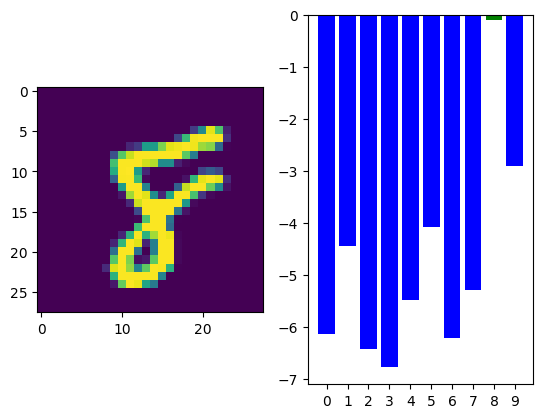

In [49]:
import matplotlib.pyplot as plt

idx = 5103
results = eval_instance(idx)
c = ["blue"] * 10
c[results["actual"]] = "green"
if not results["correct"]:
    c[results["predicted"]] = "red"    
cur_image = test_images[idx].reshape(28, 28)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(cur_image, interpolation='none')
ax2.bar([str(x) for x in range(10)], results["logits"], color=c)
plt.show()